# Welcome to the Multi-Task Learning Workshop!
In this workshop, you're going to learn how to build multi-output networks with PyTorch.<p>
Something like this image:

<font size=3 color=#BF3EFF><b> THIS ONE I TRIED USING TF.DATASET.FROM_SLICES INSTEAD OF GENERATORS. USE THIS FOR EXPERIMENTING WITH CUSTOM TRAINING LOOP AND TF.FUNCTION (IF STACKOVERFLOW ANSWERS) AND WITH CUSTOM CALLBACKS + TF DATASETS (IF WANT). V2 IS FINISHED AND IT WORKS WITH MODEL.COMPILE AND MODEL.FIT</b></font>

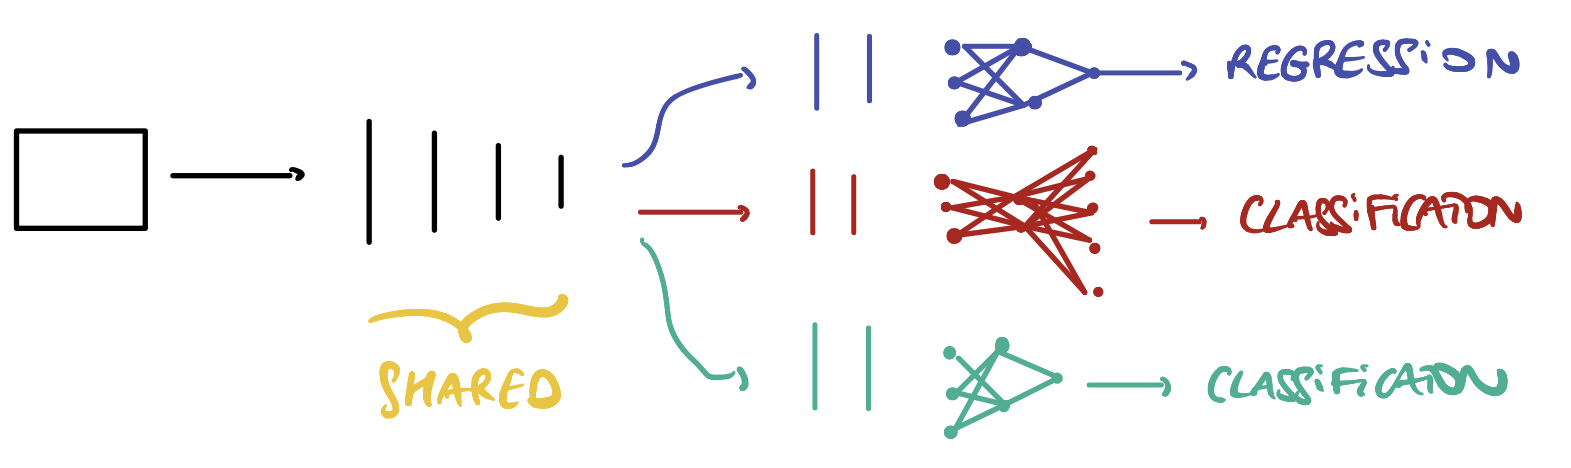

The good thing about Multi-Task Learning is that it's pretty **new**, and we **share weights**. Similarly to when transfer learning helps save time when we train our model, we're going to **save time on training, but also on inference!**. You no longer need to run 3x50 layers to have 3 tasks solved, **you can run one neural network**, and **change the heads**. With that, your network benefit from what the other tasks are learning; **it's like teaching to a class of 3 students who would share what they learn together**, instead of letting them figuring out on their own.<p>

Here's how this workshop is going to happen: 
1.  We're going to **load a multi-task learning dataset** named [UTK Face](https://susanqq.github.io/UTKFace/). It contains 24k images of faces, along with 3 labels: age, gender, and race/ethnicity.
2.  We are going to explore the dataset, and we'll realize that we need to solve **3 tasks**: binary classification (gender), multi-class classification (race), and regression (age).
3.  With PyTorch, we're going to learn how to **create a DataLoader that returns multiple labels**.
4.  To solve the tasks, we'll work with a **pretrained ResNet model**, **behead it**, and **create 3 new heads**.
5.  Finally, we'll **train the model** on a training dataset, and **test on the validation dataset**.
<p>

If you're familiar with PyTorch, this workshop might look simple, but it will be challenging to **get a great accuracy with it**. If you're new to PyTorch, you're gonna love it: We're going to **create everything from scratch**.


In [13]:
!pip install tensorflow==2.4.0

# 1 — The UTK Face Dataset
You can download the UTK Face Dataset [here](https://susanqq.github.io/UTKFace/), but I uploaded on Think Autonomous' servers. <p>
**The following wget command will download our dataset.**

![](https://images.squarespace-cdn.com/content/v1/5d6567d1afafe900010b2c70/1567268409336-V7HQTOKOVGT6OYHAER5D/utk-1.jpg)

In [14]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip

--2022-12-01 02:56:39--  https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 52.95.155.48
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|52.95.155.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131852014 (126M) [application/zip]
Saving to: ‘UTKFace.zip’

UTKFace.zip         100%[===================>] 125.74M  27.7MB/s    in 5.3s    

2022-12-01 02:56:45 (23.8 MB/s) - ‘UTKFace.zip’ saved [131852014/131852014]



In [15]:
## !jar xf UTKFace.zip
! unzip "/kaggle/working//UTKFace.zip" -d 'UTKFace'

Archive:  /kaggle/working//UTKFace.zip
   creating: UTKFace/UTKFace/
  inflating: UTKFace/__MACOSX/._UTKFace  
  inflating: UTKFace/UTKFace/9_1_2_20161219204347420.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._9_1_2_20161219204347420.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/36_0_1_20170117163203851.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._36_0_1_20170117163203851.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/86_1_0_20170120225751953.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._86_1_0_20170120225751953.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/26_1_0_20170116171048641.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._26_1_0_20170116171048641.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/1_1_2_20161219154612988.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._1_1_2_20161219154612988.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/52_0_1_20170117161018159.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._52_0_1_20170117161018159.jpg.chip.jpg  

In [16]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from torch.utils.data import Dataset
# from torchvision import transforms
import tensorflow as tf
import glob
import os
import re

In [17]:
image_paths = sorted(glob.glob("/kaggle/working/UTKFace/UTKFace/*.jpg.chip.jpg"))
# print(image_paths[0])

# 2 — Very fast Data Exploration
Based on the dataset, you can see that the entire thing is on the name of the images.<p>
For example, the image **UTKFace/100_0_0_20170112213500903.jpg.chip.jpg** can be interpreted as follows:

* UTKFace/ is a prefix
* **100 is the age**
* **0 is the gender** (0: male, 1: female)
* **0 is the race** (0:White, 1:Black, 2:Asian, 3:Indian, 4:Other)
* The rest is the date and the extension (jpg)

So: **[age] _ [gender] _ [race] _ [date&time].jpg**


The example above is the filename for image number 0. Let's pray the image we see is a very old white man.🙏🏻


In [18]:
image_paths = sorted(glob.glob("/kaggle/working/UTKFace/UTKFace/*.jpg.chip.jpg"))

images = []
ages = []
genders = []
races = []
paths = []

for path in image_paths:
#     path = str(path)
#     filename = path[12:82].split("_")
#     if len(filename)==4:
#         print(filename)
    filename = path[32:].split("_")
    if len(filename)==4:
        paths.append(path)
        images.append(np.array(Image.open(path)))
        ages.append(int(filename[0]))
        genders.append(int(filename[1]))
        races.append(int(filename[2]))

In [19]:
dataset_dict = {
    'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'
    },
    'gender_id': { 0: 'Male', 1: 'Female'
    }
}

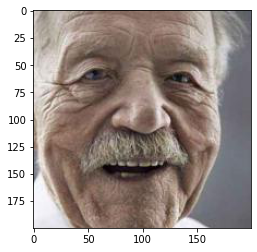

Age: 100
Gender: Male
Race: White


In [20]:
idx = np.random.randint(len(images))# Hint: Try 19006 for someone who's gonna yell motherfucka at you!

# plt.imshow(images[19006])
plt.imshow(images[0])
plt.show()

print("Age: "+str(ages[0]))
print("Gender: "+str(dataset_dict['gender_id'][genders[0]]))
print("Race: "+str(dataset_dict['race_id'][races[0]]))

## Normalization

In [21]:
min_age_value, max_age_value = min(ages), max(ages)
log_age_values = np.log10(ages)
max_age_log_value = log_age_values.max()
print('MAX AGE VALUE', max_age_value)
print('MIN AGE VALUE', min_age_value)
print('MAX AGE LOG VALUE', max_age_log_value)

MAX AGE VALUE 116
MIN AGE VALUE 1
MAX AGE LOG VALUE 2.0644579892269186


In [22]:
def get_normalized_age_value(original_age_value):
    return (original_age_value - min_age_value)/(max_age_value - min_age_value)

def get_log_age_value(original_age_value):
    return np.log10(original_age_value)/max_age_log_value

def get_original_age_from_log_value(log_age_value):
    return np.exp(log_age_value) * max_age_log_value

def get_original_age_value(normalized_age_value):
    return normalized_age_value * (max_age_value - min_age_value) + min_age_value

## More Data Exploration

Usually, we should seek for balance in the dataset, we should explore it. Let's not loose to much time here as it's not our #1 Priority.<p>
👉 Kaggle has a competition open for this dataset, and they released [a starter for the data visualization](https://www.kaggle.com/svenknoblauch/utkface-data-exploration). Let's use it directly in our work!

In [23]:
import seaborn as sns
import pandas as pd

d = {'age': ages, 'gender': genders, 'race': races}
df = pd.DataFrame(data=d)

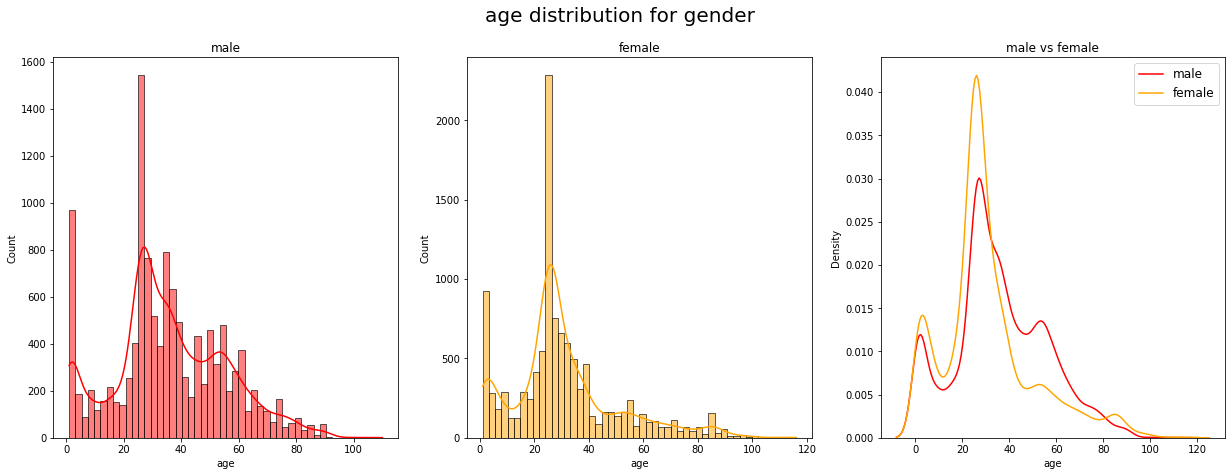

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('age distribution for gender', fontsize=20)

df_age_male = df.groupby('gender').get_group(0)
df_age_female = df.groupby('gender').get_group(1)
sns.histplot(data=df_age_male, x="age", kde=True, color="red", ax=ax1, bins=50)
sns.histplot(data=df_age_female, x="age", kde=True, color="orange", ax=ax2, bins=50)
ax1.title.set_text("male")
ax2.title.set_text("female")


sns.kdeplot(data=df_age_male, x="age", color="red", ax=ax3)
sns.kdeplot(data=df_age_female, x="age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.title.set_text("male vs female")

plt.show()

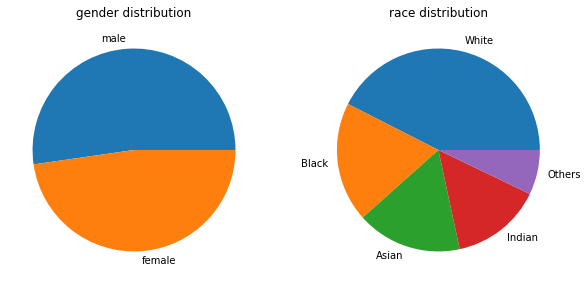

In [25]:
pie, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,6])
df.gender.value_counts().plot(kind='pie', labels=["male", "female"], pctdistance=0.5, ax = ax1)
ax1.yaxis.set_visible(False)
ax1.title.set_text('gender distribution')

df.race.value_counts().plot(kind='pie', labels=["White", "Black", "Asian", "Indian", "Others"], pctdistance=0.5, ax = ax2)
ax2.yaxis.set_visible(False)
ax2.title.set_text('race distribution')

plt.show()

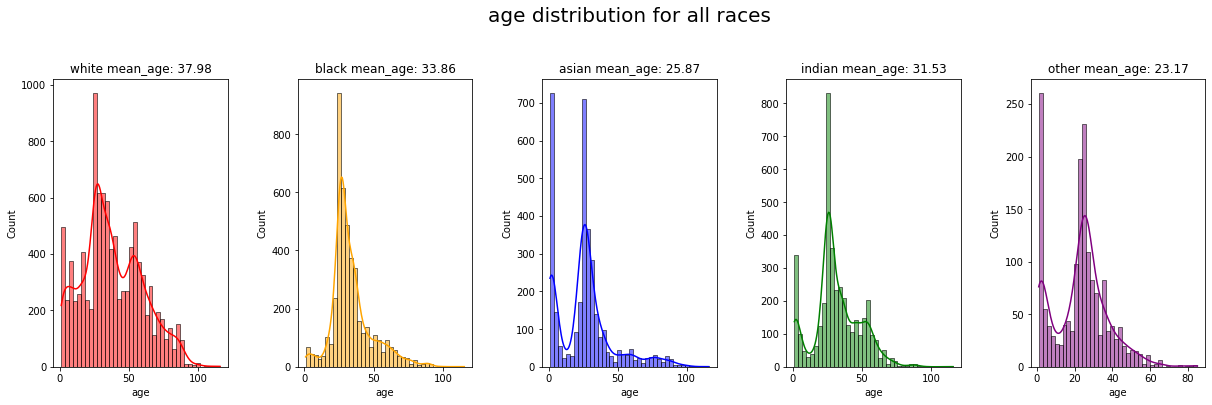

In [26]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('age distribution for all races', fontsize=20, y=1.1)
fig.tight_layout()

df_race_white = df.groupby('race').get_group(0)
sns.histplot(data=df_race_white, x="age", kde=True, color="red", ax=ax1, bins=40)
ax1.title.set_text("white mean_age: "+"%.2f" % df_race_white.mean()["age"])

df_race_black = df.groupby('race').get_group(1)
sns.histplot(data=df_race_black, x="age", kde=True, color="orange", ax=ax2, bins=40)
ax2.title.set_text("black mean_age: "+"%.2f" % df_race_black.mean()["age"])

df_race_asian = df.groupby('race').get_group(2)
sns.histplot(data=df_race_asian, x="age", kde=True, color="blue", ax=ax3, bins=40)
ax3.title.set_text("asian")
ax3.title.set_text("asian mean_age: "+"%.2f" % df_race_asian.mean()["age"])

df_race_indian = df.groupby('race').get_group(3)
sns.histplot(data=df_race_indian, x="age", kde=True, color="green", ax=ax4, bins=40)
ax4.title.set_text("indian mean_age: "+"%.2f" % df_race_indian.mean()["age"])

df_race_other = df.groupby('race').get_group(4)
sns.histplot(data=df_race_other, x="age", kde=True, color="purple", ax=ax5, bins=40)
ax5.title.set_text("other mean_age: "+"%.2f" % df_race_other.mean()["age"])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

# 3 — Create a Multi-Task DataLoader with PyTorch

In PyTorch, we usually need to create 2 elements:
* A Dataset — That will do exactly what we've done right above
* A Dataloader — That will convert our data in PyTorch format

## Dataset Minimal Code
A dataset needs to implement a class that inherits Dataset with at the minimum 3 things:
```python
def __init__(self):
def __len__(self):
def __getitem__(self):
```
Okay, there are two underscores. It doesn't mean anything bad, just that we're overwritting some functions in Python. 
* The __init__ function is what's called when we create a Dataset. 
* The __len__ function is what's returned when we check the length of our dataset (with len(dataset)). 
* The __getitem__ function is what's called when we call for one element of the dataset (with dataset[i])

In [27]:
# Just in case your images don't load properly
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [28]:
import tensorflow as tf
tf.__version__

'2.6.4'

In [29]:
df['image'] = paths
df = df[['image', 'age', 'gender', 'race']]

In [30]:
# indices = np.random.permutation(len(images))
# sample_indices = indices[0 * 64:(0 + 1) * 64]

# sample_images = []
# sample_ages = []
# sample_races = []
# sample_genders = []

# for i, sample_id in enumerate(sample_indices) :
#     img = Image.open(image_paths[i]).convert('RGB')
#     img = tf.image.resize(img, (32,32))
#     img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
#     print(len(img), ages[i], races[i], genders[i])
    
#     sample_images.append(img)
#     sample_ages.append(ages[i])
#     sample_races.append(races[i])
#     sample_genders.append(genders[i])
    
# # {'image':sample_images[0],
# # 'age':sample_ages[0],
# # 'race':sample_races[0],
# # 'gender:'sample_genders[0]}

In [31]:
# class UTKFace(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, image_paths, batch_size, shuffle):
#         'Initializat
#         ion'
#         self.mean=[0.485, 0.456, 0.406] # ImageNet
#         self.std=[0.229, 0.224, 0.225] # ImageNet
#         self.image_paths = image_paths
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.image_paths) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of images
#         list_images = [self.image_paths[k] for k in indexes]

#         # Generate data
#         images,ages,genders,races = self.__data_generation(list_images)
#         sample = sample = {'image':images, 'age':ages, 'gender':genders, 'race':races}
#         return sample
        

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.image_paths))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_images):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         images = []
#         ages = []
#         genders
#         races = []
        
#         # Generate data
#         for i, ID in enumerate(list_images):
#             filename = ID[32:].split("_")
#             if len(filename)==4:
#                 # Open the image
#                 img = Image.open(ID).convert('RGB')
#                 # Transform it
#                 img = tf.image.resize(img, (32, 32))
#                 img = (img - self.mean) / self.std
#                 images.append(img)
#                 ages.append(int(filename[0]))
#                 genders.append(int(filename[1]))
#                 races.append(int(filename[2]))
                
#         return images,ages,genders,races

In [32]:
# class UTKFace(tf.keras.utils.Sequence):
#     def __init__(self, image_paths, batch_size):
#         # Mean and Std for ImageNet
#         self.mean=[0.485, 0.456, 0.406] # ImageNet
#         self.std=[0.229, 0.224, 0.225] # ImageNet

#         # Define the Transforms
#         # self.transform = #transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(mean, std)])
#         self.batch_size = batch_size 

#         # Set Inputs and Labels
#         self.image_paths = image_paths
#         self.images = []
#         self.ages = []
#         self.genders = []
#         self.races = []
#         self.batch_size = batch_size

#         for path in image_paths:
#             path = str(path)
#             filename = path[12:81].split("_")
# #             path = re.sub("'", '', path)
#             path = path.replace("'", ''). replace('tf.Tensor(b','').replace('(','').replace(')', '').replace(', shape=, dtype=string', '')
#             if len(filename) == 4 :
#                 self.images.append(path)
#                 self.ages.append(int(filename[0][32:]))
#                 self.genders.append(int(filename[1]))
#                 self.races.append(int(filename[2]))
                
                
#     def __len__(self):
#          return len(self.images)
        
        
#     def __getitem__(self):
#         # Load an Image
#         indices = np.random.permutation(len(self.images))
#         sample_indices = indices[index * self.batch_size:(index + 1) * self.batch_size]
#         sample_images = []
#         sample_ages = []
#         sample_genders = []
#         sample_races = []
        
#         for i, sample_id in enumerate(sample_indices): 
#             # Open the image
#             img = Image.open(self.image_paths[i]).convert('RGB')
#             # Transform it
#             img = tf.image.resize(img, (32, 32))
#             img = (img - self.mean) / self.std
#             # Get the Labels
#             sample_images.append(self.images[i])
#             sample_ages.append(self.ages[i])
#             sample_genders.append(self.genders[i])
#             sample_races.append(self.races[i])
            
            

#         # Get the Labels
# #         age = self.ages[index * self.batch_size:(index + 1) * self.batch_size]
# #         gender = self.genders[index * self.batch_size:(index + 1) * self.batch_size]
# #         race = self.races[index * self.batch_size:(index + 1) * self.batch_size]
        
#         # Return the sample of the dataset
#         sample = {'image':sample_images, 'age':sample_ages, 'gender':sample_genders, 'race':sample_races}
        
#         return sample

## Train/Test Split

We will split the data into train and test sets using Dataloaders

In [33]:
# dataset = tf.data.Dataset.from_tensor_slices((df['image'], df.drop('image', axis=1)))
# def _parse_function(filename, label):
#     image_string = tf.io.read_file(filename)
#     image_decoded = tf.image.decode_jpeg(image_string, channels=3)
#     image = tf.cast(image_decoded, tf.float32)
#     return image, label

# dataset = dataset.map(_parse_function)
# dataset = dataset.batch(64)

# # step 4: create iterator and final input tensor
# iterator = iter(dataset)
# # print(iterator.get_next()[1][1])

## Dataloader

In [34]:
def preprocess_image(img) :
    mean = [0.485, 0.456, 0.406] # ImageNet
    std = [0.229, 0.224, 0.225] # ImageNet
    img = (img - mean) / std
    return img

In [38]:
BATCH_SIZE = 64

generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_image)

train_dataloader = generator.flow_from_dataframe(df, directory=None, x_col='image', y_col=['age', 'gender', 'race'], class_mode='multi_output',
                                                 color_model='rgb', target_size=(32,32), batch_size=BATCH_SIZE, shuffle=True, subset='training')

valid_dataloader = generator.flow_from_dataframe(df, directory=None, x_col='image', y_col=['age', 'gender', 'race'], class_mode='multi_output',
                                                 color_model='rgb', target_size=(32,32), batch_size=BATCH_SIZE, shuffle=False, subset='validation')

TypeError: from_generator() got an unexpected keyword argument 'validation_split'

In [ ]:
def imshow(img):
    # Unnormalize the image using the ImageNet mean and standard deviation. 
    # Unlike for PyTorch notebook we will need to denormalize using the mean and standard deviation of ImageNet
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = tf.image.resize(img, (32,32))
    # convert to Numpy
    npimg = img.numpy()
    # No need to transpose the image in order to get the correct color unlike done for PyTorch
#     img=np.transpose(img, (0, 1, 2))
    # plt.imshow(npimg[:,:,0])
    
    npimg = Image.fromarray(npimg.astype(np.uint8))
    plt.imshow(npimg)
    plt.show()

In [ ]:
sample = next(train_dataloader)
imshow(sample[0][0])

# Print the age
print(sample[1][0][0])
print(get_normalized_age_value(sample[1][0][0]))

print(dataset_dict['gender_id'][sample[1][1][0]])
print(dataset_dict['race_id'][sample[1][2][0]])

# 4 — Multi-Task Neural Network with PyTorch

In this part, we want to:
1. Define a Base Neural Network
2. Create the Heads
3. Train it
4. Test it


### Define the Base Model
In this part, we're going to load a pretrained Resnet18. **In this part, I'm going to teach you how to add layers to a pretrained network, no matter the nework, so if you'd like to load an Inception v3 and go all Dicaprio on this, be my guest!**


In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import resnet50, resnet101, resnet18, resnet34

## Create the HydraNet class


The final layer is called net.fc. If we want to add layers to that, we can always change that layer, or add layers after this one.


Here's an example when changing this final layer to a 10 neuron output:
```python
self.net = models.resnet18(pretrained=True)
self.net.fc = nn.Linear(model.fc.in_features, 10)
```

We can also use the OrderedDict method and have a set of layers (a real head!):
```python
from collections import OrderedDict
self.n_features = self.net.fc.in_features
self.net.fc1 = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(self.n_features,self.n_features)),
    ('relu1', nn.ReLU()),
    ('final', nn.Linear(self.n_features, 1))
    ]))
```

In [ ]:
class HydraNetModified:
        
    def __new__(self, net) :
        
        net.trainable = False
    
        flatten = tf.keras.layers.Flatten(name='flatten')(net.outputs[-1])

        age_head = tf.keras.layers.Dense(512, activation='relu', name='age_dense')(flatten)
        age_head = tf.keras.layers.Dense(1, activation='relu', name='age_output')(age_head)

        gender_head = tf.keras.layers.Dense(512, activation='relu', name='gender_dense')(flatten)
        gender_head = tf.keras.layers.Dense(1, activation='sigmoid', name='gender_output')(gender_head)

        race_head = tf.keras.layers.Dense(512, activation='relu', name='race_dense')(flatten)
        race_head = tf.keras.layers.Dense(5, activation='softmax', name='race_output')(race_head)

        model = tf.keras.Model(inputs=net.inputs, outputs=[age_head,gender_head,race_head]) 
        model._name = 'HydraNet'
        
        return model

In [ ]:
net = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))
net._name = 'HydraNetResNet50'

model = HydraNetModified(net)
# model.summary()


race_loss = tf.keras.losses.SparseCategoricalCrossentropy()
gender_loss = tf.keras.losses.BinaryCrossentropy()
age_loss = tf.keras.losses.MeanAbsoluteError()

val_race_loss = tf.keras.losses.SparseCategoricalCrossentropy()
val_gender_loss = tf.keras.losses.BinaryCrossentropy()
val_age_loss = tf.keras.losses.MeanAbsoluteError()

# race_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
# gender_metrics = tf.keras.metrics.BinaryAccuracy()
# age_metrics = tf.keras.metrics.MeanAbsoluteError()



lr = 1e-4
momentum = 0.09
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

##################
# model.to(device=device)

# race_loss = nn.CrossEntropyLoss() # Includes Softmax
# gender_loss = nn.BCELoss() # Don't include Softmax
# age_loss = nn.L1Loss()

# lr = 1e-4
# momentum = 0.09 # Meaning that we will go 9% with the previous direction
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
# inputs = tf.keras.layers.Input(shape=(32,32,3), name='Input')
# x = net(inputs, training=False)
# flatten = tf.keras.layers.Flatten(name='Flatten')(x)
# age_dense = tf.keras.layers.Dense(512, activation='softmax', name='AgeDense')(flatten)
# age_output = tf.keras.layers.Dense(1, activation='relu', name='AgeOutput')(age_dense)

# gender_dense = tf.keras.layers.Dense(512, activation='softmax', name='GenderDense')(flatten)
# gender_output = tf.keras.layers.Dense(1, activation='relu', name='GenderOutput')(gender_dense)

# race_dense = tf.keras.layers.Dense(512, activation='softmax', name='RaceDense')(flatten)
# race_output = tf.keras.layers.Dense(5, activation='softmax', name='RaceOutput')(race_dense)

# model = tf.keras.Model(inputs, [age_output, gender_output, race_output])
# tf.keras.utils.plot_model(model)

## Train the Model

In [ ]:
# model.compile(optimizer=optimizer, 
#               loss={
#                   'AgeOutput': age_loss, 
#                   'RaceOutput': race_loss, 
#                   'GenderOutput': gender_loss},
#               loss_weights={
#                   'AgeOutput': 4., 
#                   'RaceOutput': 1.5, 
#                   'GenderOutput': 0.1},
#               metrics={
#                   'AgeOutput': 'mae', 
#                   'RaceOutput': 'accuracy',
#                   'GenderOutput': 'accuracy'})

In [ ]:
def loss_fn(y_batch_train, logits) :
#     print('Age :', y_batch_train[0])
#     print('Gender :', y_batch_train[1])
#     print('Race :', y_batch_train[2])
#     print('Logit :', logits)
    loss_1 = race_loss(y_batch_train[2], np.asarray(logits[2]))
    loss_2 = gender_loss(y_batch_train[1], np.asarray(logits[1]))
    loss_3 = age_loss(y_batch_train[0], np.asarray(logits[0]))
    
    loss = loss_1 + loss_2 + loss_3
    
    losses = [loss_1, loss_2, loss_3]
    
    return loss, losses

<font size=3 color=black><b>By default TensorFlow uses Eager Execution which is slow compared to Graph Execution, especially in this case where the usage of `ImageDataGenerator` is involved. Thus we will use graph execution which can be done using `@tf.function` for our training and validation</b></font>

In [ ]:
tf.config.run_functions_eagerly(True) 

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y = tf.convert_to_tensor(y)
        tape.watch(y)
        logits = model(x, training=True)
        loss_value, losses = loss_fn(tf.convert_to_tensor(y), logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss_value, losses


@tf.function
def valid_step(x, y):
    val_logits = model(x, training=False)
    loss_value, losses = loss_fn(y, val_logits)
    
    return loss_value, val_losses

In [ ]:
epochs = 2

for epoch in range(2) :
    print('EPOCH', epoch)
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataloader) :
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
       
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        # Compute the loss value for this minibatch as well.
        loss_value = train_step(x_batch_train, y_batch_train)
        
        # race_metrics.update_state(y_batch_train, logits)
        # gender_metrics.update_state(y_batch_train, logits)
        # age_metrics.update_state(y_batch_train, logits)
        
    print('Training Losses: Race: ' + str(losses[0].numpy()) + ', Gender: ' + str(losses[1].numpy()) + ', Age: ' + str(losses[2].numpy()))

#     for x_batch_val, y_batch_val in valid_dataloader:
#         val_loss_value, val_losses = valid_step(x_batch_val, y_batch_val)

#     print('Validation Losses: Race: ' + str(val_losses[0].numpy()) + ', Gender: ' + str(val_losses[1].numpy()) + ', Age: ' + str(val_losses[2].numpy()))

In [ ]:
epochs = 2

for epoch in range(2) :
    print('EPOCH', epoch)
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataloader) :
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape :
            
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch
            
            # Compute the loss value for this minibatch.
            loss_value, losses = loss_fn(y_batch_train, logits)
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # race_metrics.update_state(y_batch_train, logits)
        # gender_metrics.update_state(y_batch_train, logits)
        # age_metrics.update_state(y_batch_train, logits)
        
    print('Training Losses: Race: ' + str(losses[0].numpy()) + ', Gender: ' + str(losses[1].numpy()) + ', Age: ' + str(losses[2].numpy()))

    for x_batch_val, y_batch_val in valid_dataloader:
        val_logits = model(x_batch_val, training=False)
        loss_value, val_losses = loss_fn(y_batch_val, val_logits)

    print('Validation Losses: Race: ' + str(val_losses[0].numpy()) + ', Gender: ' + str(val_losses[1].numpy()) + ', Age: ' + str(val_losses[2].numpy()))

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

n_epochs = 10

logger = {"train_loss": list(),
          "validation_loss": list(),
          "train_gender_loss": list(),
          "train_race_loss": list(),
          "train_age_loss": list(),
          "validation_gender_loss": list(),
          "validation_race_loss": list(),
          "validation_age_loss": list(),
          }

In [ ]:
sig = nn.Sigmoid()

for epoch in range(n_epochs):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_gender_loss = 0
    training_race_loss = 0
    training_age_loss = 0
    validation_gender_loss = 0
    validation_race_loss = 0
    validation_age_loss = 0

    for i, data in enumerate(train_dataloader):
        inputs = data["image"].to(device=device)
        age_label = get_normalized_age_value(data["age"]).to(device=device)
        gender_label = data["gender"].to(device=device)
        race_label = data["race"].to(device=device)

        optimizer.zero_grad()
        age_output, gender_output, race_output = model(inputs)
        
        loss_1 = race_loss(race_output, race_label)
        loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
        loss_3 = age_loss(age_output, age_label.unsqueeze(1).float())

        loss = loss_1 + loss_2 + loss_3

        loss.backward()
        optimizer.step()
        total_training_loss += loss
        
        training_race_loss += loss_1.item()
        training_gender_loss += loss_2.item()
        training_age_loss += loss_3.item()
    print('EPOCH ', epoch+1)
    print("Training Losses: Race: {}, Gender: {}, Age: {}".format(loss_1, loss_2, loss_3))

    with torch.no_grad():
        model.eval()

        for i, data in enumerate(val_dataloader):
            inputs = data["image"].to(device=device)
            age_label = get_normalized_age_value(data["age"]).to(device=device)
            gender_label = data["gender"].to(device=device)
            race_label =  data["race"].to(device=device)
            age_output, gender_output, race_output = model(inputs)
        
            loss_1 = race_loss(race_output, race_label)
            loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
            loss_3 = age_loss(age_output, age_label.unsqueeze(1).float())

            loss = loss_1 + loss_2 + loss_3
            total_validation_loss += loss

            validation_race_loss += loss_1.item()
            validation_gender_loss += loss_2.item()
            validation_age_loss += loss_3.item()
        print("Validation Losses: Race: {}, Gender: {}, Age: {}".format(loss_1, loss_2, loss_3))

    avgTrainLoss = total_training_loss / train_steps
    avgValLoss = total_validation_loss / val_steps
    
    print('Average Losses — Training: {} | Validation {}'.format(avgTrainLoss, avgValLoss))
    print() 
    avgTrainGenderLoss = training_gender_loss/len(train_dataloader.dataset)
    avgTrainRaceLoss = training_race_loss/len(train_dataloader.dataset)
    avgTrainAgeLoss = training_age_loss/len(train_dataloader.dataset)

    avgValGenderLoss = validation_gender_loss/len(val_dataloader.dataset)
    avgValRaceLoss = validation_race_loss/len(val_dataloader.dataset)
    avgValAgeLoss = validation_age_loss/len(val_dataloader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_gender_loss"].append(avgTrainGenderLoss)
    logger["train_race_loss"].append(avgTrainRaceLoss)
    logger["train_age_loss"].append(avgTrainAgeLoss)
    
    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_gender_loss"].append(avgValGenderLoss)
    logger["validation_race_loss"].append(avgValRaceLoss)
    logger["validation_age_loss"].append(avgValAgeLoss)


In [ ]:
torch.save(model.state_dict(), "best_model.pth")

## Show the Results

In [ ]:
plt.plot(logger["train_loss"])
plt.plot(logger["validation_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_gender_loss"])
plt.plot(logger["validation_gender_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_race_loss"])
plt.plot(logger["validation_race_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_age_loss"])
plt.plot(logger["validation_age_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Inference

In [ ]:
indexes = valid_dataset.indices
test_indices = indexes[0:10]

In [ ]:
for idx in test_indices:
    plt.figure()
    plt.imshow(images[idx])
    plt.show()

    image_norm = images[idx] / 255.0
    image_norm = (torch.from_numpy(image_norm).view(1, 3, image_norm.shape[0], image_norm.shape[1]).float())

    model.eval()
    age, gender, race = model(image_norm.to(device=device))

    predicted_age = int(get_original_age_value(age.squeeze(0).item()))

    print("Age:", str(ages[idx]), "| Predicted:", str(int(predicted_age)))

    sigmoid = nn.Sigmoid()
    out_gender = int(torch.round(sigmoid(gender)).item())
    gender_classes = ["male", "female"]
    print("Gender:", str(dataset_dict['gender_id'][genders[idx]]), "| Predicted:", str(gender_classes[out_gender]))

    out_race = torch.argmax(F.softmax(race, dim=1)).item()
    race_classes = ["white", "black", "asian", "indian", "other"]
    print("Race:", str(dataset_dict['race_id'][races[idx]]), "| Predicted:", str(race_classes[out_race]))
    print('\n')